In [50]:
# Importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Importing machine learning libraries
from category_encoders import LeaveOneOutEncoder
from sklearn.model_selection import cross_validate, KFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import  ElasticNet, Lasso, LinearRegression, LassoCV, Ridge, RidgeCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression
from sklearn.calibration import cross_val_predict


In [51]:
# Load the dataset
sal_data = pd.read_csv('ds_salaries.csv')
# display 10 random samples from the dataset
sal_data.sample(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
77,2023,SE,FT,Data Architect,168100,USD,168100,US,100,US,M
2938,2022,MI,FT,Product Data Analyst,140000,USD,140000,US,100,US,M
2184,2022,MI,FT,Data Analyst,109000,USD,109000,US,0,US,M
2061,2022,SE,FT,Data Engineer,194000,USD,194000,US,100,US,M
3550,2021,MI,FT,Data Engineer,140000,USD,140000,US,100,US,L
31,2023,SE,FT,Data Engineer,253200,USD,253200,US,0,US,M
2924,2022,SE,FT,Data Scientist,191475,USD,191475,US,100,US,M
1087,2023,SE,FT,Machine Learning Engineer,269000,USD,269000,CA,100,CA,M
667,2023,SE,FT,Data Scientist,175000,USD,175000,US,0,US,M
2200,2022,SE,FT,Data Engineer,40000,EUR,42026,ES,0,ES,M


In [52]:
# Getting the information about the dataset
sal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [53]:
# Checking the counts of unique values in each column
sal_data.nunique()



work_year                4
experience_level         4
employment_type          4
job_title               93
salary                 815
salary_currency         20
salary_in_usd         1035
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

There are too many job titles and locations so I'll exclude titles and locations with less than 10 entries


In [54]:
# Getting the counts of unique values in the 'job_title' and 'company_location' columns
counts = sal_data['job_title'].value_counts()
location = sal_data['company_location'].value_counts()
# Filtering the dataset to include only job titles with more than 10 occurrences
sal_data = sal_data[(sal_data['job_title'].isin(counts[counts > 10].index))&
                    (sal_data['company_location'].isin(location[location>10].index))]
sal_data.nunique()

work_year               4
experience_level        4
employment_type         4
job_title              26
salary                749
salary_currency         9
salary_in_usd         900
employee_residence     32
remote_ratio            3
company_location       12
company_size            3
dtype: int64

We now have the top 26 job titles and the top 11 locations available in data science.

<Figure size 800x500 with 0 Axes>

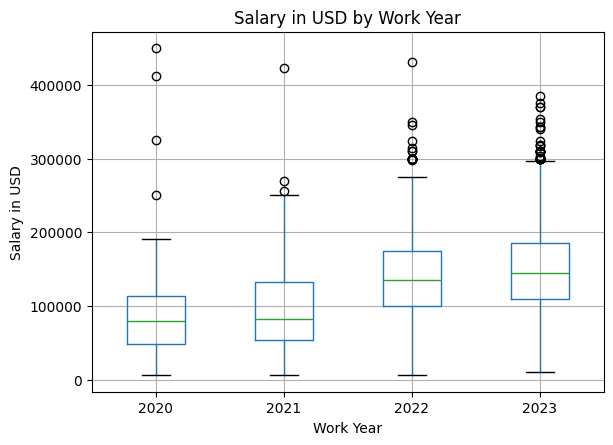

In [55]:
# A boxplot of salary in USD by work year
plt.figure(figsize=(8, 5))
sal_data.boxplot(column='salary_in_usd', by='work_year')
plt.xlabel('Work Year')
plt.ylabel('Salary in USD')
plt.title('Salary in USD by Work Year')
plt.suptitle('')
plt.show()


Th increase in outliers shows the increment in salaries due to factors not in this dataset. It shows the importance of the work year column in training a suitable model

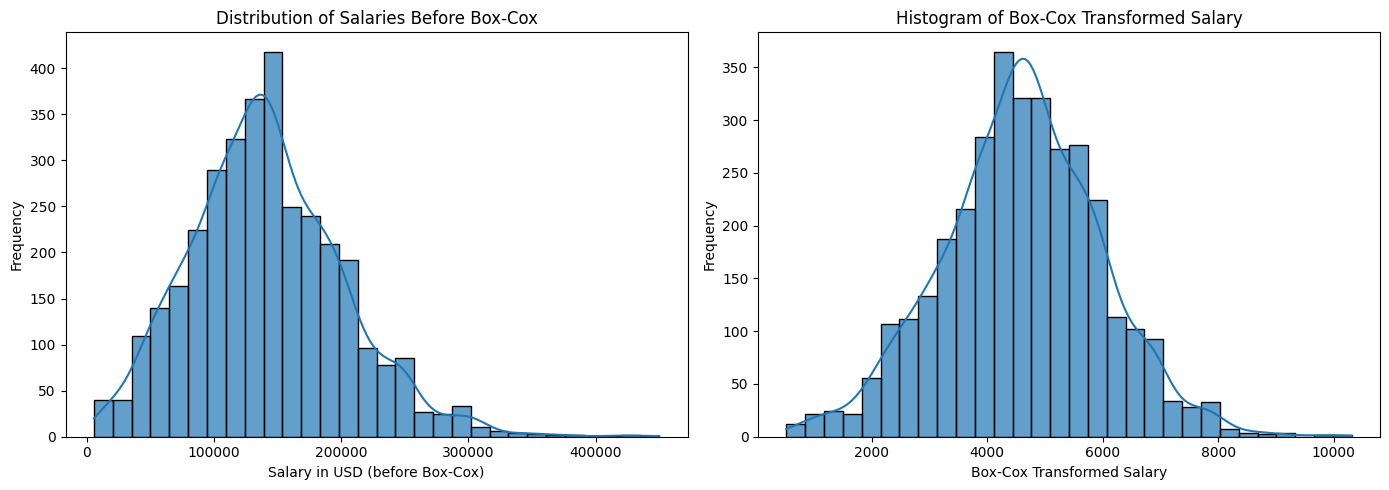

In [56]:
# A boxcox transformation of the 'salary_in_usd' column
sal_data['boxcox_salary'], fitted_lambda = boxcox(sal_data['salary_in_usd'])

# A histogram of 'salary_in_usd' column and the boxcox transformation of 'salary_in_usd'
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(sal_data['salary_in_usd'],bins=30, kde=True, edgecolor='black', ax=axes[0], alpha=0.7)
axes[0].set_xlabel('Salary in USD (before Box-Cox)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Salaries Before Box-Cox')

sns.histplot(sal_data['boxcox_salary'], bins=30, kde=True, edgecolor='black', ax=axes[1], alpha=0.7)
axes[1].set_xlabel('Box-Cox Transformed Salary')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Box-Cox Transformed Salary')

plt.tight_layout()
plt.show()

Models will be trained for the salary(before and after transformation) to see which performs best

In [ ]:
# Encoding all categorical columns
# Define columns to encode
ordinal_col = ['experience_level']
# loo = Leave One Out Encoder
loo_col = ['employment_type', 'job_title', 'company_size', 'company_location']
numeric_col = ['work_year', 'remote_ratio']

# Setting the ordered level 
ordered_levels = [['EN', 'MI', 'SE', 'EX']]  # Ordered from entry-level to executive
#['Entry-level', 'Mid-level', 'Senior-level', 'Executive'] # Understandable labels


# Defining the full preprocessor to be included in a pipeline
# for tree-based models
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=ordered_levels, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_col),
        ('loo', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), loo_col)
    ],
    remainder='passthrough'  # Keep other columns as they are
)
# for linear models
linear_preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=ordered_levels, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_col),
        ('loo', LeaveOneOutEncoder(), loo_col),
        ('scaler', StandardScaler(), numeric_col)
    ],
    remainder='passthrough'  # Keep other columns as they are
)

In [58]:
# Dropping columns that are not needed 
sal_data.drop(columns=['salary', 'salary_currency', 'employee_residence'], inplace=True) 

# Splitting the dataset into features and target variable
X = sal_data.drop(columns=['salary_in_usd', 'boxcox_salary'])
y_boxcox = sal_data['boxcox_salary']
y_normal = sal_data['salary_in_usd']

# Instantiating all models in a dictionary
models = {
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Elastic Net': ElasticNet(random_state=42)
}




In [59]:
# Creating an empty dictionary to load the pipeline
pipelines = {}

# Looping through each model
for name, model in models.items():
    if name == 'Elastic Net':
        preprocessor = linear_preprocessor
        selector = SelectKBest(score_func=f_regression, k='all')  # using a linear friendly selector for the model
    else:
        preprocessor = tree_preprocessor
        selector =  SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='mean')  # using the Random Forest selector for tree-based models

    pipeline = Pipeline(steps=[('preprocessing', preprocessor),
                           ('feature_selection', selector), 
                           ('model', model)])

    # Entry into the pipeline dictionary
    pipelines[name] = pipeline

In [60]:
# Creating a target dictionary to avoid repetition
target_dict = {
    'Box-Cox': y_boxcox,
    'Normal': y_normal
}


# looping through each model in the pipelines dictionary
for target_name, y in target_dict.items():
    print(f'Training models for {target_name} target...')

    for name, pipeline in pipelines.items():
        print(f"Training {name} model...")

        # Cross-validation setup
        cv_results = cross_validate(
            pipeline, X, y,
            cv=KFold(n_splits=5, shuffle=True, random_state=42),
            scoring=['neg_root_mean_squared_error', 'r2'],
            return_train_score=False
        )

        # Calculating RMSE and R squared scores
        rmse = -cv_results['test_neg_root_mean_squared_error'].mean()  # Negate because sklearn returns negative RMSE
        r2 = cv_results['test_r2'].mean()
    
        print(f"{name} - RMSE: {rmse:.2f}, R^2: {r2:.2f}")

        # Inverse Box-Cox predictions and evaluate on original scale
        if target_name == 'Box-Cox':
            y_pred_boxcox = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))
            y_pred_inverse = inv_boxcox(y_pred_boxcox, fitted_lambda)

            # Compare to original target (y_normal)
            rmse_inv = root_mean_squared_error(y_normal, y_pred_inverse)
            r2_inv = r2_score(y_normal, y_pred_inverse)

            print(f"{name} (inverse Box-Cox) - RMSE: {rmse_inv:.2f}, R^2: {r2_inv:.2f}")
    
        # Fitting the pipeline to the data
        pipeline.fit(X, y)
    
        selector = pipeline.named_steps['feature_selection']
        preprocessor = pipeline.named_steps['preprocessing']
        mask = selector.get_support()
    
        feature_names = []
        for step_name, transformer, cols in preprocessor.transformers_:
            if transformer == 'passthrough':
                feature_names.extend(cols)
            else:
                try:
                    # Works if encoder has get_feature_names_out
                    names = transformer.get_feature_names_out(cols)
                    feature_names.extend(names)
                except:
                    # Fallback for category_encoders, etc.
                    feature_names.extend(cols)

        # Apply mask to get selected feature names
        selected_features = [name for name, keep in zip(feature_names, mask) if keep]

        # Display selected features
        print(f"Selected {len(selected_features)} features:")
        print("  ", selected_features)

    

    



Training models for Box-Cox target...
Training Gradient Boosting model...
Gradient Boosting - RMSE: 1047.13, R^2: 0.42
Gradient Boosting (inverse Box-Cox) - RMSE: 47626.84, R^2: 0.38
Selected 3 features:
   ['experience_level', 'job_title', 'company_location']
Training Random Forest model...
Random Forest - RMSE: 1052.72, R^2: 0.42
Random Forest (inverse Box-Cox) - RMSE: 47878.22, R^2: 0.37
Selected 3 features:
   ['experience_level', 'job_title', 'company_location']
Training XGBoost model...
XGBoost - RMSE: 1059.96, R^2: 0.41
XGBoost (inverse Box-Cox) - RMSE: 48212.26, R^2: 0.36
Selected 3 features:
   ['experience_level', 'job_title', 'company_location']
Training Decision Tree model...
Decision Tree - RMSE: 1067.93, R^2: 0.40
Decision Tree (inverse Box-Cox) - RMSE: 48487.83, R^2: 0.35
Selected 3 features:
   ['experience_level', 'job_title', 'company_location']
Training Elastic Net model...
Elastic Net - RMSE: 1072.83, R^2: 0.40
Elastic Net (inverse Box-Cox) - RMSE: 48749.21, R^2: 0.

from this it is clear that there is no significant difference between the inverse boxcox and the normal salary, so we'll stick with the normal. Next I'll carry out feature selection again and retrain on those features

 

In [61]:
# Feature selection for linear models
# performing a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_normal, test_size=0.2, random_state=42)

alphas = np.logspace(-4, 2, 200)

# create a pipeline and tune Lasso's alpha to pick the best alpha
pipeline = Pipeline([('preprocessor', linear_preprocessor),
    ('scaler', StandardScaler()),
    ('lasso_cv', LassoCV(alphas=alphas, cv=5, random_state=9))
])

pipeline.fit(X_train, y_train)

# getting the best alpha value
best_alpha = pipeline.named_steps['lasso_cv'].alpha_

print("Best alpha:", best_alpha)

Best alpha: 100.0


In [62]:
# creating a new pipeline 
new_pl = Pipeline([('preprocessor', linear_preprocessor),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=best_alpha))
])

new_pl.fit(X_train, y_train)

# get feature names from transformers
ordinal_names = ordinal_col  
loo_names = loo_col          
scaler_names = numeric_col   
passthrough_cols = list(set(X_train.columns) - set(ordinal_col) - set(loo_col) - set(numeric_col))

# Final list of all features
feat = ordinal_names + loo_names + scaler_names + passthrough_cols


# Get the Lasso model from the pipeline
lasso = new_pl.named_steps['lasso']

# Selecting features  based on coef and plotting them
selected_features = [name for name, coef in zip(feat, lasso.coef_) if abs(coef) > 1000.1]
print("Selected features:", selected_features)

Selected features: ['experience_level', 'job_title', 'company_size', 'company_location', 'work_year']


In [63]:
# Fit preprocessor on training data
linear_preprocessor.fit(X_train, y_train)

# Transform train and test
X_train_transformed = linear_preprocessor.transform(X_train)
X_test_transformed = linear_preprocessor.transform(X_test)

# Convert transformed data to DataFrame for better readability
feature_names = linear_preprocessor.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Map selected_features to their transformed column names
selected_features_transformed = [
    'ordinal__experience_level',
    'loo__job_title',
    'loo__company_size',
    'loo__company_location',
    'scaler__work_year'
]

# subsetting train and test sets for selected features
X_train_selected_linear = X_train_transformed_df[selected_features_transformed]
X_test_selected_linear = X_test_transformed_df[selected_features_transformed]

# Define the linear models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Elastic Net": ElasticNet(alpha=1.0, l1_ratio=0.5)
}

# Train and evaluate each model
rmse_results = {}
for name, model in models.items():
    model.fit(X_train_selected_linear, y_train)
    y_pred = model.predict(X_test_selected_linear)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_results[name] = rmse

# Show results
print("Model Performance (RMSE Scores):")
for name, score in rmse_results.items():
    print(f"{name}: {score:.4f}")

# computing the model's accuracy
for name, model in models.items():
    y_pred = model.predict(X_test_selected_linear)
    r2 = r2_score(y_test, y_pred)
    accuracy_percent = r2 * 100 
    print(f"{name} Accuracy: {accuracy_percent:.2f}%")

Model Performance (RMSE Scores):
Linear Regression: 45424.5860
Ridge Regression: 45425.3501
Elastic Net: 46546.9750
Linear Regression Accuracy: 44.65%
Ridge Regression Accuracy: 44.65%
Elastic Net Accuracy: 41.88%


In [64]:
# Feature selection for tree-based model
rf = RandomForestRegressor(random_state=42) # model to be used to select the features

# Define hyperparameter search space
param_dist = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['log2', 'sqrt']
}

# Pipeline
pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('model', rf)
])

# RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=9,
    n_jobs=-1
)

# Fit search
search.fit(X_train, y_train)

# Best model
best_model = search.best_estimator_

# Get feature names after encoding
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Get importances
importances = best_model.named_steps['model'].feature_importances_

# Filter important features
important_indices = np.argsort(importances)[::-1]
top_features = [(feature_names[i], importances[i]) for i in important_indices if importances[i] > 0.01]

# Display
for name, imp in top_features:
    print(f"{name}: {imp:.4f}")



loo__company_location: 0.3111
loo__job_title: 0.2678
ordinal__experience_level: 0.2603
remainder__work_year: 0.0718
remainder__remote_ratio: 0.0428
loo__company_size: 0.0419


In [65]:
# Fit preprocessor on training data
tree_preprocessor.fit(X_train, y_train)

# Transform train and test
X_train_transformed_tree = tree_preprocessor.transform(X_train)
X_test_transformed_tree = tree_preprocessor.transform(X_test)

# Convert transformed data to DataFrame for better readability
feature_names_tree = tree_preprocessor.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names_tree)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names_tree)

# Map selected_features to their transformed column names
selected_features_transformed_tree = [
    'ordinal__experience_level',
    'loo__job_title',
    'loo__company_size',
    'loo__company_location',
    'remainder__work_year',
    'remainder__remote_ratio'
]

# subsetting train and test sets for selected features
X_train_selected_tree = X_train_transformed_df[selected_features_transformed_tree]
X_test_selected_tree = X_test_transformed_df[selected_features_transformed_tree]
# Define the tree-based models
tree_models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42)
}

# Train and evaluate each tree-based model
rmse_results_tree = {}
for name, model in tree_models.items():
    model.fit(X_train_selected_tree, y_train)
    y_pred = model.predict(X_test_selected_tree)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_results_tree[name] = rmse
    
# Show results
print("Tree-Based Model Performance (RMSE Scores):")
for name, score in rmse_results_tree.items():
    print(f"{name}: {score:.4f}")

# computing the model's accuracy    
for name, model in tree_models.items():
    y_pred = model.predict(X_test_selected_tree)
    r2 = r2_score(y_test, y_pred)
    accuracy_percent = r2 * 100 
    print(f"{name} Accuracy: {accuracy_percent:.2f}%")

Tree-Based Model Performance (RMSE Scores):
Gradient Boosting: 45295.7364
Random Forest: 46545.6141
XGBoost: 47772.4326
Decision Tree: 49963.1258
LightGBM: 45792.8436
Gradient Boosting Accuracy: 44.96%
Random Forest Accuracy: 41.88%
XGBoost Accuracy: 38.78%
Decision Tree Accuracy: 33.03%
LightGBM Accuracy: 43.75%


In [66]:
# Fine tuning Gradient Boosting regressor
gbr = GradientBoostingRegressor(random_state=42)
param_dist_gbr = {"n_estimators": [50, 100, 200, 300],
                 "max_depth": [i for i in range(1, 11)],
                 "min_samples_split": [2, 5, 10],
                 "min_samples_leaf": [1, 2, 3, 4],
                 "learning_rate": [np.round(i, 2) for i in np.arange(0.01, 0.5, 0.01)]}

# RandomizedSearchCV for Gradient Boosting
search_gbr = RandomizedSearchCV(
    gbr, param_distributions=param_dist_gbr, n_iter=50,
    cv=5, scoring='neg_mean_squared_error',
    random_state=42, verbose=2, n_jobs=-1
)

# Fit search
search_gbr.fit(X_train_selected_tree, y_train)

# Best model
best_gbr = search_gbr.best_estimator_
y_pred_gbr = best_gbr.predict(X_test_selected_tree)
rmse_gbr = root_mean_squared_error(y_test, y_pred_gbr)
print(f"RMSE for best Gradient Boosting model: {rmse_gbr:.4f}")

# Compute R squared for Gradient Boosting
r2_gbr = r2_score(y_test, y_pred_gbr)
accuracy_percent_gbr = r2_gbr * 100
print(f"Gradient Boosting Accuracy: {accuracy_percent_gbr:.2f}%")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE for best Gradient Boosting model: 45022.6818
Gradient Boosting Accuracy: 45.62%


Now I'll try an ensemble learning technique to get a better rmse and r2 score


In [67]:
# Ensemble predictions using simple averaging
lin_model = models['Linear Regression'].fit(X_train_selected_linear, y_train)
y_pred_lin = lin_model.predict(X_test_selected_linear)
y_pred_ensemble = (y_pred_lin + y_pred_gbr) / 2
rmse_ensemble = root_mean_squared_error(y_test, y_pred_ensemble)
print(f"RMSE for Ensemble Model: {rmse_ensemble:.4f}")
r2_ensemble = r2_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {r2_ensemble * 100:.2f}%")

RMSE for Ensemble Model: 44891.7032
Ensemble Model Accuracy: 45.94%


It didn't improve the accuracy significantly so I'll fine tune both ridge and lgbm then use it alongside Lin.Reg. and GBR in a stacking ensemble
 

In [68]:
# Tuning a ridge model
ridge = Ridge(random_state=42)
param_dist_ridge = {
    'alpha': np.logspace(-4, 4, 50),
    'fit_intercept': [True, False]
}
# RandomizedSearchCV for Ridge Regression
search_ridge = RandomizedSearchCV(
    ridge, param_distributions=param_dist_ridge, n_iter=50,
    cv=5, scoring='neg_mean_squared_error',
    random_state=42, verbose=2, n_jobs=-1
)
# Fit search
search_ridge.fit(X_train_selected_linear, y_train)
# Best model
best_ridge = search_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_selected_linear)
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
print(f"RMSE for best Ridge model: {rmse_ridge:.4f}")
# Compute R squared for Ridge
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Model Accuracy: {r2_ridge * 100:.2f}%")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE for best Ridge model: 45433.5497
Ridge Model Accuracy: 44.63%


In [69]:
# Tuning a LGBM regressor
lgbm = LGBMRegressor(verbose=-1, random_state=42)
param_dist_lgbm = {
    'n_estimators': [i for i in range(50, 701, 50)],
    'max_depth': [i for i in range(-1, 11)],
    'learning_rate': [np.round(i, 2) for i in np.arange(0.01, 0.5, 0.01)],
    'num_leaves': [15, 31, 63, 127],
    'min_child_samples': [5, 10, 20, 30, 40],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# RandomizedSearchCV for LGBM Regressor
search_lgbm = RandomizedSearchCV(
    lgbm, param_distributions=param_dist_lgbm, n_iter=50,
    cv=5, scoring='neg_mean_squared_error',
    random_state=42, n_jobs=-1
)

# Fit search and predict
search_lgbm.fit(X_train_selected_tree, y_train)
best_lgbm = search_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test_selected_tree)
rmse_lgbm = root_mean_squared_error(y_test, y_pred_lgbm)
print(f"RMSE for best LGBM model: {rmse_lgbm:.4f}")
# Compute R squared for LGBM
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f"LGBM Model Accuracy: {r2_lgbm * 100:.2f}%")

RMSE for best LGBM model: 45088.1554
LGBM Model Accuracy: 45.46%


In [ ]:
# Ensemble predictions using stacking
estimators = [
    ('linear', LinearRegression()),
    ('ridge', best_ridge),
    ('lightgbm', best_lgbm),
    ('gbr', best_gbr)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(alphas=np.logspace(-4, 4, 50)),
    cv=5,
    n_jobs=-1
)
# Fit stacking model
stacking_model.fit(X_train_selected_tree, y_train)
# Predict and evaluate
y_pred_stacking = stacking_model.predict(X_test_selected_tree)
rmse_stacking = root_mean_squared_error(y_test, y_pred_stacking)
print(f"RMSE for Stacking Model: {rmse_stacking:.4f}")  
# Compute R squared for Stacking
r2_stacking = r2_score(y_test, y_pred_stacking) 
print(f"Stacking Model Accuracy: {r2_stacking * 100:.2f}%")

RMSE for Stacking Model: 44818.7056
Stacking Model Accuracy: 46.11%


This is the best accuracy giving the dataset being less than 4000 rows